In [21]:
import numpy as np
import math
import os
import random
import queue
import matplotlib.pyplot as pl

In [22]:
NP=6 #Number of processes
PAGE_SIZE=4096 #Page size in bytes
F=16 #Number of Frames
INVALID = -10
PID=0
FRAME = 1 #Used for indexing into frames
pr_timing = np.zeros(F).astype('int32')

COMPLETED=10
INCOMPLETE=20


IN_MEMORY = 1
MEM_FAULT = 50
PAGE_REPLACE = 100


phys_mem = np.full((F,2), INVALID).astype('int32') #Initial Physical memory addresses
phys_mem

array([[-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10],
       [-10, -10]])

In [23]:
def init_proc_queue():
    pq=queue.Queue(maxsize=NP)
    proc_queue=list(set((NP*np.random.random(20)).astype('int32')))
    random.shuffle(proc_queue)
    for pr in proc_queue:
        pq.put_nowait(pr)
        
    print(proc_queue)
init_proc_queue()

[0, 5, 2, 4, 3, 1]


In [24]:
def correct_refs(alist,cent,maxpg):
    if cent!=0:
        pgnum=int(cent/PAGE_SIZE)
        lh=(pgnum+1)*PAGE_SIZE-1
        ll=pgnum*PAGE_SIZE
    else:
        lh=maxpg*PAGE_SIZE
        ll=0
        
    for i in range(alist.shape[0]):
        if alist[i]>=lh:
            alist[i]=lh-1
        if alist[i]<ll:
            alist[i]=ll+1
    return alist

def sim_process(M,sigma,outfile,lfrac=0.9):
    cur_page=int(M*np.random.random()) #Generating random start page
    cur_locale=round(PAGE_SIZE*(cur_page+0.5)) #Generating location of current page
    sum_refs=0
    list_locales=list()
    for count in range(M):
        num_refs=int(512+(PAGE_SIZE-512)*np.random.random())
        sum_refs+=num_refs
        list_locales.append(cur_page)
        num_loc=round(lfrac*num_refs)
        aref_list=np.random.normal(cur_locale,sigma*300+100,num_loc)
#         aref_list=correct_refs(aref_list,cur_locale,M)
        aref_list=aref_list.astype('int32')
        cur_page=int(M*np.random.random())
        cur_locale=round(PAGE_SIZE*(cur_page+0.5))
        num_trans=round((1-lfrac)*num_refs)
        tref_list=np.random.random(num_trans)*cur_locale
#         tref_list=correct_refs(tref_list,0,M)
        tref_list=tref_list.astype('int32')
        np.append(aref_list,tref_list).tofile(outfile,sep='\n')
        outfile.write('\n')
    return list_locales,sum_refs
        
      
    print('Current Page',cur_page)
    print('Current Location',cur_locale)
    print('List of Locations',list_locales)
    
npg = int(np.random.normal(10,2.5))
nsig = int(5 * np.random.random())    
fname = 'AR_' + '{:02d}'.format(0) + '.txt'
fname=open(fname,'w')
sim_process(npg,nsig,fname)

([1, 0, 3, 3, 1, 0], 12974)

In [25]:
int(512+(PAGE_SIZE-512)*np.random.random())

3092

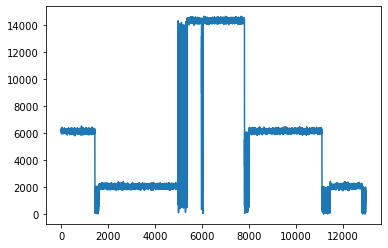

In [26]:
file=np.loadtxt('AR_00.txt')
pl.plot(file)

In [27]:
pr_size=np.zeros(NP,dtype='int32')

for p in range(NP):
    fname='AR_'+'{:02d}'.format(p)+'.txt'
    op=open(fname,'w')
    npg=int(np.random.normal(10,2.5))
    nsig=int(5*np.random.random())
    print(f'Process {p} requires {npg} pages and has a quality {nsig}')
    pg_seq,pr_size[p]=sim_process(npg,nsig,op)
    print(pg_seq,pr_size[p])
    op.write('\n')
    op.close()
    print('written process',p,'to ',fname)

Process 0 requires 9 pages and has a quality 2
[2, 6, 3, 1, 4, 1, 8, 3, 1] 21488
written process 0 to  AR_00.txt
Process 1 requires 11 pages and has a quality 3
[8, 3, 3, 7, 2, 10, 0, 7, 4, 7, 2] 24820
written process 1 to  AR_01.txt
Process 2 requires 8 pages and has a quality 0
[5, 0, 5, 3, 4, 4, 4, 5] 15745
written process 2 to  AR_02.txt
Process 3 requires 10 pages and has a quality 3
[6, 2, 1, 4, 7, 6, 4, 4, 4, 1] 19402
written process 3 to  AR_03.txt
Process 4 requires 7 pages and has a quality 1
[1, 0, 5, 3, 1, 4, 6] 12405
written process 4 to  AR_04.txt
Process 5 requires 5 pages and has a quality 0
[1, 2, 4, 3, 3] 12532
written process 5 to  AR_05.txt


21488


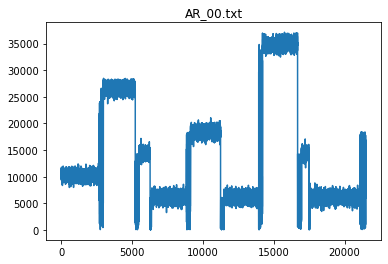

24819


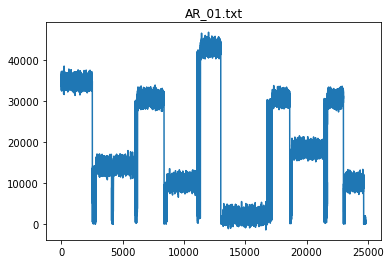

15745


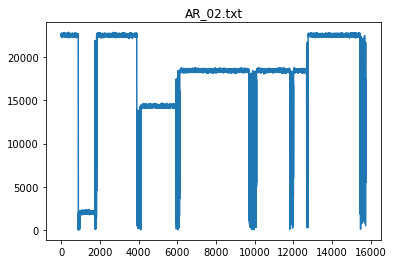

19402


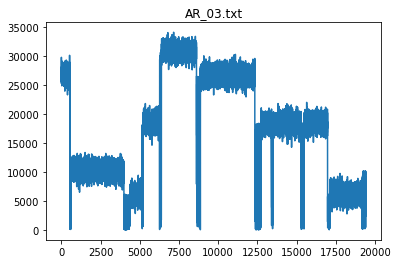

12405


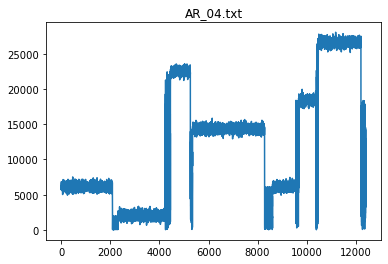

12531


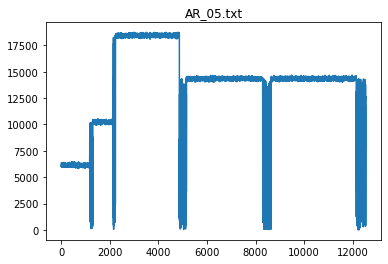

In [28]:
for p in range(NP):
    fname='AR_'+'{:02d}'.format(p)+'.txt'
    temp=np.loadtxt(fname)
    print(len(temp))
    pl.plot(range(len(temp)),temp)
    pl.title(fname)
    pl.show()

In [29]:
def init_phys_mem():
    for i in range(F):
        phys_mem[i,PID]=INVALID
        phys_mem[i,FRAME]=INVALID
        
init_phys_mem()

In [32]:
def update_phys_mem(pid):
    for i in range(F):
        if phys_mem[i,PID]==pid:
            phys_mem[i,PID]=INVALID
            phys_mem[i,FRAME]=INVALID

            
def memory_manager(infile,outfile,pid):
    num_adr=512+int(4096*np.random.random())
    idx=0 #counter to increase and read addresses.
    
    while idx<num_adr:
        add_ref=infile.readline().strip() #This will load all the address line by line
                                        #Also considered as virtual addresses.
        if add_ref=='':
            break #Finished reading address references
            
        add_ref=int(add_ref)  #Address reference
        pg_num=int(add_ref/PAGE_SIZE) #Page number to keep track of
        pg_offset=add_ref%PAGE_SIZE #Page offset.
        pg_base,pg_fault=get_pageframe(pg_num,pid) #Get page offset and page fault if occured 
                                                    #eslse initialize page for memory
        
        if pg_base>=0:
            phys_addr=pg_base+pg_offset
            outfile.write(str(add_ref)+','+str(phys_addr)+','
                         +str(pg_fault)+'\n')
            
            if pg_fault==0:
                pr_timing[pid]+=IN_MEMORY
            elif pg_fault==1:
                pr_timing[pid]+=MEM_FAULT
            else:
                pr_timing[pid]+=PAGE_REPLACE
        else:
            print(idx)
            return INVALID
        idx+=1
        
    if idx>=num_adr:
        return INCOMPLETE
    return COMPLETED
            
        
        
        
        
    
    
    print(num_adr)
    
def get_pageframe(pnum, pr) :
    fr_num = 0  #Initialize frame number to 0
    while fr_num < F : #Loop until counter reaches to all frames
        if phys_mem[fr_num,PID] == pr and phys_mem[fr_num,FRAME] == pnum : #if process is found in a frame, stop loop
            break                                                          #and keep track of frame number
        else :
            fr_num += 1  #Increase counter for frame

    if fr_num < F : #If the searched frame number is less than the available frames,
        return fr_num * PAGE_SIZE, 0 #Return frame number x 4096 i.e page base with page fault 0 i.e fault didnt occur.
                                    # Process is in main memory
    fr_num = gen_pagefault(pnum, pr) #Since frame number was greater than frame size so generate page fault.
                                    #So search for the frame and try to load in physical memory
    
    if fr_num>=0:  #check for the frame number returned from pagefault and return page fault occured once.
        return fr_num*PAGE_SIZE,1
    
    fr_num=gen_pagefault(pnum,pr) #check for the frame number returned from page fault once more if previously wasnt >0.
    
    if fr_num>=0: 
        return fr_num*PAGE_SIZE,2 #This is to replace the page into main memory
    
    return INVALID,0 #If the required frame is not found, return Invalid
    
    
    
def gen_pagefault(pgnum, pr) :
    fr_num = 0 #Initialize frame number to 0
    while fr_num < F and phys_mem[fr_num,FRAME] >= 0 : #Loop untill frame number is not less than Frame number
                                                        #and physical memory's frame number,Frame index >=0 i.e valid
        fr_num += 1                                    # Increment frame number.
    
    if fr_num >= F :  #If frame number is greater than Frame Size than its Invalid i.e it is not present in memory.
        return INVALID
    
    #If fault didnt occur than  update physical memory and execute the process
    phys_mem[fr_num,FRAME] = pgnum     #Update physical memory with current page number
    phys_mem[fr_num,PID] = pr          #update physical memory with current process id
    return fr_num                      #return frame number in which Hit was occured.
        

    
memory_manager(open('AR_00.txt'),open('AR_00out.txt','w'),1)

20